## Imports

In [1]:
import sys
import os
import argparse
import time
import random
import math
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt

import torch
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tfs

from tensorboardX import SummaryWriter


from utils import kNN, AverageMeter, py_softmax

In [2]:
model_name = "VGG"
magic_dim = 9216

# model_name = "ResNet"
# magic_dim = 512

In [3]:
dataset_name = "LSST"

## Training parameters

In [4]:
#data
datadir = "/root/data/Multivariate_ts"

# optimization
lamb = 10      # SK lambda-parameter
nopts = 400    # number of SK-optimizations
epochs = 20   # numbers of epochs
momentum = 0.9 # sgd momentum
exp = './resnet1d_exp' # experiments results dir


# other
devc='0'  # cuda device
batch_size = 500
lr=0.003     #learning rate
alr=0.03    #starting learning rate

knn_dim = 10
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [5]:
device = torch.device('cuda:' + devc) if torch.cuda.is_available() else torch.device('cpu')
print(f"GPU device: {torch.cuda.current_device()}")

GPU device: 0


## Data Preparation

In [6]:
import pandas as pd
import numpy as np
from scipy.io import arff
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sktime.utils.load_data import load_from_tsfile_to_dataframe

from tqdm import tqdm
import os
from datetime import datetime

In [7]:
def features_to_torch(X):
    X = X.applymap(np.array)
    dimensions_lst = []

    for dim in X.columns:
        dimensions_lst.append(np.dstack(list(X[dim].values))[0])

    dimensions_lst = np.array(dimensions_lst)
    X = torch.from_numpy(np.array(dimensions_lst, dtype=np.float64))
    X = X.transpose(0, 2)
    X = X.transpose(1, 2)
    X = F.normalize(X, dim=1)
    return X.float()

def answers_to_torch(y):
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    y = torch.from_numpy(np.array(y, dtype=np.int32))
    y = y.long()
    return y

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt], excerpt

In [8]:
X_train, y_train = load_from_tsfile_to_dataframe(datadir + f'/{dataset_name}/{dataset_name}_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(datadir + f'/{dataset_name}/{dataset_name}_TEST.ts')

X_train = features_to_torch(X_train)
X_test = features_to_torch(X_test)

y_train = answers_to_torch(y_train)
y_test = answers_to_torch(y_test)

In [9]:
N = X_train.shape[0]
time_steps = X_train.shape[2]
dims_num = X_train.shape[1]
num_classes = len(np.unique(y_train))

print('time_steps:', time_steps)
print('train samples_num:', N)
print('dims_num:', dims_num)
print('num_classes:', num_classes)

time_steps: 36
train samples_num: 2459
dims_num: 6
num_classes: 14


## Model parameters (AlexNet in that case)

In [10]:
hc=10                 # number of heads
ncl=num_classes       # number of clusters

numc = [ncl] * hc
# # (number of filters, kernel size, stride, pad) for AlexNet, two vesions
# CFG = {
#     'big': [(96, 11, 4, 2), 'M', (256, 5, 1, 2), 'M', (384, 3, 1, 1), (384, 3, 1, 1), (256, 3, 1, 1), 'M'],
#     'small': [(64, 11, 4, 2), 'M', (192, 5, 1, 2), 'M', (384, 3, 1, 1), (256, 3, 1, 1), (256, 3, 1, 1), 'M']
# }

## Models

### ResNet

In [11]:
__all__ = ['resnetv1','resnetv1_18']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, in_channel=3, width=1, num_classes=[1000]):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.headcount = len(num_classes)
        self.base = int(16 * width)
        self.features = nn.Sequential(*[                                                     # [100, 8, 18]
                            nn.Conv1d(in_channel, 16, kernel_size=3, padding=1, bias=False), # [100, 16, 36]
                            nn.BatchNorm1d(16),
                            nn.ReLU(inplace=True),
                            self._make_layer(block, self.base, layers[0]),                   # [100, 16, 36]
                            self._make_layer(block, self.base * 2, layers[1]),               # [100, 32, 36]
                            self._make_layer(block, self.base * 4, layers[2]),               # [100, 64, 36]
                            self._make_layer(block, self.base * 8, layers[3]),               # [100, 128, 36]
                            nn.AvgPool1d(2),                                                 # [100, 128, 18]
        ])
    
        if len(num_classes) == 1:
            self.top_layer = nn.Sequential(nn.Linear(magic_dim, num_classes[0]))
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(magic_dim, i))
            self.top_layer = None
        for m in self.features.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x.float())
        out = out.view(out.size(0), -1)
        if self.headcount == 1:
            if self.top_layer:
                out = self.top_layer(out)
            return out
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(out))
            return outp

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

def resnetv1_18(num_classes=[1000]):
    """Encoder for instance discrimination and MoCo"""
    return resnet18(num_classes=num_classes)

### VGG

In [12]:
class VGG(nn.Module):
    def __init__(self, num_classes):
        super(VGG, self).__init__()
        self.headcount = len(num_classes)
        
        self.features = nn.Sequential(*[                                                     # [100, 8, 18]
                            nn.Conv1d(dims_num, 64, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
#                             nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
#                             nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
#                             nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
#                             nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
                            nn.AvgPool1d(kernel_size=2)#, stride=2, padding=0, dilation=1, ceil_mode=False),
        ])
        
        if len(num_classes) == 1:
            self.top_layer = nn.Sequential(nn.Linear(magic_dim, num_classes[0]))
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(magic_dim, i))
            self.top_layer = None
    
    def forward(self, x):
        out = self.features(x.float())  # [50, 10, 400] -> [50, 512, 12]
        out = out.view(out.size(0), -1) # [50, magic_dim]
        if self.headcount == 1:
            if self.top_layer:
                out = self.top_layer(out)
                print (out.size())
            return out
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(out))
            return outp

## Sinkhorn-Knopp optimization

In [13]:
def optimize_L_sk(PS):
    N, K = PS.shape
    tt = time.time()
    PS = PS.T  # now it is K x N
    r = np.ones((K, 1)) / K
    c = np.ones((N, 1)) / N
    PS **= lamb  # K x N
    inv_K = 1. / K
    inv_N = 1. / N
    err = 1e3
    _counter = 0
    while err > 1e-2:
        r = inv_K / (PS @ c)  # (KxN)@(N,1) = K x 1
        c_new = inv_N / (r.T @ PS).T  # ((1,K)@(KxN)).t() = N x 1
        if _counter % 10 == 0:
            err = np.nansum(np.abs(c / c_new - 1))
        c = c_new
        _counter += 1
        
    print("error: ", err, 'step ', _counter, flush=True)  # " nonneg: ", sum(I), flush=True)
    # inplace calculations.
    PS *= np.squeeze(c)
    PS = PS.T
    PS *= np.squeeze(r)
    PS = PS.T
    argmaxes = np.nanargmax(PS, 0)  # size N
    newL = torch.LongTensor(argmaxes)
    selflabels = newL.to(device)
    PS = PS.T
    PS /= np.squeeze(r)
    PS = PS.T
    PS /= np.squeeze(c)
    sol = PS[argmaxes, np.arange(N)]
    np.log(sol, sol)
    cost = -(1. / lamb) * np.nansum(sol) / N
    print('cost: ', cost, flush=True)
    print('opt took {0:.2f}min, {1:4d}iters'.format(((time.time() - tt) / 60.), _counter), flush=True)
    return cost, selflabels

def opt_sk(model, selflabels_in, epoch):
    if hc == 1:
        PS = np.zeros((N, ncl))
    else:
        PS_pre = np.zeros((N, magic_dim)) # knn_dim
    
    for batch_idx, (data, _, _selected) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
        data = data.to(device)#cuda()
        if hc == 1:
            p = nn.functional.softmax(model(data), 1)
            PS[_selected, :] = p.detach().cpu().numpy()
        else:
            p = model(data.float())
            PS_pre[_selected, :] = p.detach().cpu().numpy() # p: [20, magic_dim]
    if hc == 1:
        cost, selflabels = optimize_L_sk(PS)
        _costs = [cost]
    else:
        _nmis = np.zeros(hc)
        _costs = np.zeros(hc)
        nh = epoch % hc  # np.random.randint(args.hc)
        print("computing head %s " % nh, end="\r", flush=True)
        tl = getattr(model, "top_layer%d" % nh)
        # do the forward pass:
        PS = (PS_pre @ tl.weight.cpu().numpy().T
                   + tl.bias.cpu().numpy())
        PS = py_softmax(PS, 1)
        c, selflabels_ = optimize_L_sk(PS)
        _costs[nh] = c
        selflabels_in[nh] = selflabels_
        selflabels = selflabels_in
    return selflabels

In [14]:
def plot_acc(acc, model_name, dataset_name):
    step = 3
    x = np.arange(1, epochs//step + 1)
    acc = acc[::step]
    plt.plot(x*step, acc[1:])
    plt.xlabel("# epoch")
    plt.ylabel("Accuracy, %")
    plt.grid(True)
    plt.title(f"Train accuracy, self-labeling, {model_name}, {dataset_name}")

## Training utils

In [15]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = alr
    if epochs == 200:
        if epoch >= 80:
            lr = alr * (0.1 ** ((epoch - 80) // 40))  # i.e. 120, 160
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 400:
        if epoch >= 160:
            lr = alr * (0.1 ** ((epoch - 160) // 80))  # i.e. 240,320
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 800:
        if epoch >= 320:
            lr = alr * (0.1 ** ((epoch - 320) // 160))  # i.e. 480, 640
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 1600:
        if epoch >= 640:
            lr = alr * (0.1 ** ((epoch - 640) // 320))
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [16]:
def feature_return_switch(model, bool=True):
    """
    switch between network output or conv5features
        if True: changes switch s.t. forward pass returns post-conv5 features
        if False: changes switch s.t. forward will give full network output
    """
    if bool:
        model.headcount = 1
    else:
        model.headcount = hc
    model.return_feature = bool

In [17]:
def train(epoch, selflabels):
    print('\nEpoch: %d' % epoch)
    print(model_name)
    adjust_learning_rate(optimizer, epoch)
    train_loss = AverageMeter()
    data_time = AverageMeter()
    batch_time = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    
    for batch_idx, (inputs, targets, indexes) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
        inputs = inputs.float().to(device)
        niter = epoch * N // batch_size + batch_idx
        if niter * batch_size >= optimize_times[-1]:
            with torch.no_grad():
                _ = optimize_times.pop()
                if hc >1:
                    feature_return_switch(model, True)
                selflabels = opt_sk(model, selflabels, epoch)
                if hc >1:
                    feature_return_switch(model, False)
        data_time.update(time.time() - end)
        inputs, targets = inputs.to(device), targets.to(device)#, indexes.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        if hc == 1:
            loss = criterion(outputs, selflabels[indexes])
        else:
            loss = torch.mean(torch.stack([criterion(outputs[h], selflabels[h, indexes]) for h in range(hc)]))

        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
#         if True:
        if batch_idx % 10 == 0:
            print('Epoch: [{}][{}/{}]'
                  'Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) '
                  'Data: {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Loss: {train_loss.val:.4f} ({train_loss.avg:.4f})'.format(
                epoch, batch_idx, N // batch_size, batch_time=batch_time, data_time=data_time, train_loss=train_loss))
#             writer.add_scalar("loss", loss.item(), batch_idx*512 +epoch*N/batch_size)
    return selflabels

## Model initialization

In [18]:
if model_name == "ResNet":
    model = resnet18(num_classes=numc, in_channel=dims_num)
else:
    model = VGG(num_classes=numc)
print (model_name, "created")

VGG created


In [19]:
optimize_times = ((epochs + 1.0001)*N*(np.linspace(0, 1, nopts))[::-1]).tolist()
optimize_times = [(epochs +10)*N] + optimize_times
print('We will optimize L at epochs:', [np.round(1.0*t/N, 2) for t in optimize_times], flush=True)

We will optimize L at epochs: [30.0, 21.0, 20.95, 20.89, 20.84, 20.79, 20.74, 20.68, 20.63, 20.58, 20.53, 20.47, 20.42, 20.37, 20.32, 20.26, 20.21, 20.16, 20.11, 20.05, 20.0, 19.95, 19.89, 19.84, 19.79, 19.74, 19.68, 19.63, 19.58, 19.53, 19.47, 19.42, 19.37, 19.32, 19.26, 19.21, 19.16, 19.11, 19.05, 19.0, 18.95, 18.89, 18.84, 18.79, 18.74, 18.68, 18.63, 18.58, 18.53, 18.47, 18.42, 18.37, 18.32, 18.26, 18.21, 18.16, 18.11, 18.05, 18.0, 17.95, 17.89, 17.84, 17.79, 17.74, 17.68, 17.63, 17.58, 17.53, 17.47, 17.42, 17.37, 17.32, 17.26, 17.21, 17.16, 17.11, 17.05, 17.0, 16.95, 16.89, 16.84, 16.79, 16.74, 16.68, 16.63, 16.58, 16.53, 16.47, 16.42, 16.37, 16.32, 16.26, 16.21, 16.16, 16.11, 16.05, 16.0, 15.95, 15.89, 15.84, 15.79, 15.74, 15.68, 15.63, 15.58, 15.53, 15.47, 15.42, 15.37, 15.32, 15.26, 15.21, 15.16, 15.11, 15.05, 15.0, 14.95, 14.89, 14.84, 14.79, 14.74, 14.68, 14.63, 14.58, 14.53, 14.47, 14.42, 14.37, 14.32, 14.26, 14.21, 14.16, 14.11, 14.05, 14.0, 13.95, 13.89, 13.84, 13.79, 13.74

In [20]:
# init selflabels randomly
if hc == 1:
    selflabels = np.zeros(N, dtype=np.int32)
    for qq in range(N):
        selflabels[qq] = qq % ncl
    selflabels = np.random.permutation(selflabels)
    selflabels = torch.LongTensor(selflabels).to(device)
else:
    selflabels = np.zeros((hc, N), dtype=np.int32)
    for nh in range(hc):
        for _i in range(N):
            selflabels[nh, _i] = _i % numc[nh]
        selflabels[nh] = np.random.permutation(selflabels[nh])
    selflabels = torch.LongTensor(selflabels).to(device)

In [21]:
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [22]:
writer = SummaryWriter(f'./runs/{dataset_name}')

## Training! 
Takes a couple of minutes per epoch

In [23]:
def my_kNN(net, K, sigma=0.1, dim=128, use_pca=False):
    net.eval()
    # this part is ugly but made to be backwards-compatible. there was a change in cifar dataset's structure.
    trainLabels = y_train
    LEN = N
    C = trainLabels.max() + 1

    trainFeatures = torch.zeros((magic_dim, LEN))  # , device='cuda:0') # dim
    normalize = Normalize()
    for batch_idx, (inputs, targets, _) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=False)):
        batchSize = batch_size
        inputs = inputs.cuda()
        features = net(inputs.float())
        if not use_pca:
            features = normalize(features)
        trainFeatures[:, batch_idx * batchSize:batch_idx * batchSize + batchSize] = features.data.t().cpu()
        
    if use_pca:
        comps = 4
        print('doing PCA with %s components'%comps, end=' ')
        from sklearn.decomposition import PCA
        pca = PCA(n_components=comps, whiten=False)
        trainFeatures = pca.fit_transform(trainFeatures.numpy().T)
        trainFeatures = torch.Tensor(trainFeatures)
        trainFeatures = normalize(trainFeatures).t()
        print('..done')
    def eval_k_s(K_,sigma_):
        total = 0
        top1 = 0.
        top5 = 0.

        with torch.no_grad():
            retrieval_one_hot = torch.zeros(K_, C)# .cuda()
            for batch_idx, (inputs, targets, _) in enumerate(iterate_minibatches(X_test, y_test, batch_size, shuffle=False)):
                targets = targets # .cuda(async=True) # or without async for py3.7
                inputs = inputs.cuda()
                batchSize = batch_size
                features = net(inputs)
                if use_pca:
                    features = pca.transform(features.cpu().numpy())
                    features = torch.Tensor(features).cuda()
                features = normalize(features).cpu()

                dist = torch.mm(features, trainFeatures)

                yd, yi = dist.topk(K_, dim=1, largest=True, sorted=True)
                candidates = trainLabels.view(1, -1).expand(batchSize, -1)
                retrieval = torch.gather(candidates, 1, yi).long()

                retrieval_one_hot.resize_(batchSize * K_, C).zero_()
                retrieval_one_hot.scatter_(1, retrieval.view(-1, 1), 1.)
                
                yd_transform = yd.clone().div_(sigma_).exp_()
                probs = torch.sum(torch.mul(retrieval_one_hot.view(batchSize, -1, C),
                                            yd_transform.view(batchSize, -1, 1)),
                                  1)
                _, predictions = probs.sort(1, True)

                # Find which predictions match the target
                correct = predictions.eq(targets.data.view(-1, 1))

                top1 = top1 + correct.narrow(1, 0, 1).sum().item()
                top5 = top5 + correct.narrow(1, 0, 5).sum().item()

                total += targets.size(0)

        print(f"{K_}-NN,s={sigma_}: TOP1: ", top1 * 100. / total)
        return top1 / total

    if isinstance(K, list):
        res = []
        for K_ in K:
            for sigma_ in sigma:
                res.append(eval_k_s(K_, sigma_))
        return res
    else:
        res = eval_k_s(K, sigma)
        return res

In [24]:
accuracies = []
best_accuracies = []
start = time.time()

for epoch in range(start_epoch, start_epoch + epochs):
    selflabels = train(epoch, selflabels)
    feature_return_switch(model, True)
    
    acc = my_kNN(model, K=10, sigma=0.1, dim=knn_dim)
    accuracies.append(acc)
    feature_return_switch(model, False)
#     writer.add_scalar("accuracy kNN", acc, epoch)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'opt': optimizer.state_dict(),
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/best_ckpt.t7' % (exp))
        best_acc = acc
        best_accuracies.append(best_acc)
    if epoch % 100 == 0:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'opt': optimizer.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/ep%s.t7' % (exp, epoch))
    if epoch % 50 == 0:
        feature_return_switch(model, True)
        acc = my_kNN(model, K=[50, 10], sigma=[0.1, 0.5], dim=knn_dim, use_pca=True)
        i = 0
#         for num_nn in [50, 10]:
#             for sig in [0.1, 0.5]:
#                 writer.add_scalar('knn%s-%s' % (num_nn, sig), acc[i], epoch)
#                 i += 1
        feature_return_switch(model, False)
    print('best accuracy: {:.2f}'.format(best_acc * 100))
end = time.time()

# checkpoint = torch.load('%s'%exp+'/best_ckpt.t7' )
# model.load_state_dict(checkpoint['net'])
feature_return_switch(model, True)
acc = my_kNN(model, K=10, sigma=0.1, dim=knn_dim, use_pca=True)


Epoch: 0
VGG
error:  0.0 step  11
cost:  2.6355855209450105
opt took 0.00min,   11iters
Epoch: [0][0/4]Time: 0.292 (0.292) Data: 0.202 (0.202) Loss: 2.6387 (2.6387)
error:  3.6222874699731733e-09 step  31
cost:  3.514087336898735
opt took 0.00min,   31iters
error:  1.251115217981713e-06 step  11
cost:  2.5011527757794134
opt took 0.00min,   11iters
error:  4.791978706064626e-07 step  11
cost:  2.5201848989108364
opt took 0.00min,   11iters
10-NN,s=0.1: TOP1:  25.6
Saving..
Saving..
doing PCA with 4 components ..done
50-NN,s=0.1: TOP1:  26.35
50-NN,s=0.5: TOP1:  26.35
10-NN,s=0.1: TOP1:  24.5
10-NN,s=0.5: TOP1:  24.55
best accuracy: 25.60

Epoch: 1
VGG
error:  1.4075383081291193e-09 step  11
cost:  2.4979447697746746
opt took 0.00min,   11iters
Epoch: [1][0/4]Time: 0.235 (0.235) Data: 0.170 (0.170) Loss: 2.6138 (2.6138)
error:  0.00039365705268556983 step  11
cost:  2.299137568940669
opt took 0.00min,   11iters
error:  5.92175612289525e-05 step  11
cost:  2.3379773772011823
opt took 0.

error:  0.007531093639683184 step  71
cost:  2.6236246615226886
opt took 0.00min,   71iters
10-NN,s=0.1: TOP1:  32.95
best accuracy: 38.05

Epoch: 16
VGG
error:  0.003694374658156252 step  91
cost:  2.7564363831031
opt took 0.00min,   91iters
Epoch: [16][0/4]Time: 0.231 (0.231) Data: 0.166 (0.166) Loss: 1.9574 (1.9574)
error:  0.006803512193455319 step  111
cost:  2.667986983456185
opt took 0.00min,  111iters
error:  0.009200507534560809 step  151
cost:  2.62516183261115
opt took 0.00min,  151iters
error:  0.00584825028928837 step  121
cost:  2.403013245752802
opt took 0.00min,  121iters
10-NN,s=0.1: TOP1:  33.95
best accuracy: 38.05

Epoch: 17
VGG
error:  0.004846558107547194 step  151
cost:  2.8843215276785985
opt took 0.00min,  151iters
Epoch: [17][0/4]Time: 0.238 (0.238) Data: 0.173 (0.173) Loss: 2.0180 (2.0180)
error:  0.006288331616299936 step  191
cost:  2.9969393624112333
opt took 0.00min,  191iters
error:  0.008300182627599462 step  161
cost:  2.6989434233462624
opt took 0.00m

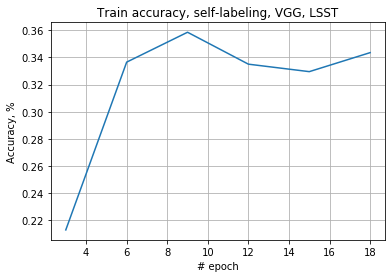

In [25]:
plot_acc(accuracies, model_name, dataset_name);

In [26]:
print ("Self-labeling")
print ("-------------------------")
print ("Model:     ", model_name)
print ("Dataset:   ", dataset_name)
print ("Epochs:    ", epochs)
print ("lr:        ", lr)
print ("Batch size:", batch_size)
print ("Heads:     ", hc)
print ("Time:      ", end-start)
print ("Best acc:  ", best_acc*100, "%")

Self-labeling
-------------------------
Model:      VGG
Dataset:    LSST
Epochs:     20
lr:         0.003
Batch size: 500
Heads:      10
Time:       29.579330444335938
Best acc:   38.05 %
